##  Hi again, my beautiful kagglers.

Let's jump into the second playground competition of the year 2021.  
As from today, I decided to share my monthly work with you. 
Please, don't hesitate to comment and upvote.  

---

LONG TIME AGO: basic and advanced feature engineering, catboost and lgbm models, xgboost   

IN THIS VERSION:  xgb and lightgbm predictors, feature transformation. LGBM and catboost fit process are disabled to reduce a computation time. Shap is also disabled.  

UP NEXT: more complex models, shap.

---

LGBM prediction `sub_305` is made by my other [kernel](https://www.kaggle.com/kirillklyukvin/tps-feb-lgbm) based on beautiful [work](https://www.kaggle.com/maunish/lgbm-goes-brrr) by Mister [Maunish](https://www.kaggle.com/maunish).  

Some ideas I took from [this notebook](https://www.kaggle.com/tunguz/ensembling-starter-tps-feb-2021) by Mister [Bojan](https://www.kaggle.com/tunguz).   

Friends, let's show our appreciation and upvote their notebooks too!

---

## Data and libs

In [1]:
import numpy as np 
import pandas as pd 
import re
import sys, gc, os
from IPython.display import display

from scipy import stats

import shap
shap.initjs()
import featuretools as ft

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, Normalizer, MaxAbsScaler
from sklearn.preprocessing import (StandardScaler, PowerTransformer, QuantileTransformer ,LabelEncoder, 
                                   OneHotEncoder, OrdinalEncoder)

import catboost as cb
import lightgbm as lgb
from xgboost import XGBRegressor

In [2]:
df_train = pd.read_csv('../input/tabular-playground-series-feb-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-feb-2021/test.csv')
df_sub = pd.read_csv('../input/tabular-playground-series-feb-2021/sample_submission.csv')

SEED = 1991


### My and another lovely kagglers latest submissions with the best score  

sub_295 = pd.read_csv('../input/tp-f-my-subs/submission_001.csv')
sub_202 = pd.read_csv('../input/feb84202/FEB84202.csv')
sub_222 = pd.read_csv('../input/tp-f-my-subs/submission_021.csv')
sub_216 = pd.read_csv('../input/tp-f-my-subs/submission_216.csv')
sub_257 = pd.read_csv('../input/tp-f-my-subs/submission_257.csv')
sub_279 = pd.read_csv('../input/tp-f-my-subs/submission_012.csv')
sub_305 = pd.read_csv('../input/tp-f-my-subs/submission_lgb_305.csv')
sub_212 = pd.read_csv('../input/tp-f-my-subs/submission_037.csv')

## EDA

In [3]:
def simple_eda(df):
    
    """
    This function helps us with simple data analysis.
    We may explore the common information about the dataset, missing values, features distribution and duplicated rows
    """
    
    # applying info() method
    print('---')
    print('Common information')
    print('---')
    print()
    print(df.info())
    
    # missing values
    print()
    print('---')
    if df.isna().sum().sum() == 0:
        print('There are no missing values')
        print('---')
    else:
        print('Detected')
        display(df.isna().sum())
    
    
    # applying describe() method for categorical features
    print()
    print('---')
    print('Categorical columns')
    print('Total {}'.format(len(df.select_dtypes(include='object').columns)))
    print('---')
    display(df.describe(include = 'object'))
    
    # same describe() but for continious features
    print('---')
    print('Continuous columns')
    print('Total {}'.format(len(df.select_dtypes(include=['int', 'float']).columns)))
    print('---')
    display(df.describe())
    
    #checking for duplicated rows
    if df.duplicated().sum() == 0:
        print('---')
        print('There are no duplicates')
        print('---')
    else:
        print('---')
        print('Duplicates found')
        print('---')
        display(df[df.duplicated()])
    
    print()
    print('---')
    print('End of the report')

In [4]:
simple_eda(df_train)

---
Common information
---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-n

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
count,300000,300000,300000,300000,300000,300000,300000,300000,300000,300000
unique,2,2,2,4,4,4,8,8,7,15
top,A,A,A,C,B,B,A,E,C,F
freq,281471,162678,276551,183752,297373,149208,292643,267631,121054,107281


---
Continuous columns
Total 16
---


,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,250018.576947,0.524634,0.506649,0.444115,0.446214,0.455471,0.508337,0.478345,0.455904,0.459321,0.526899,0.504943,0.529938,0.524549,0.503349,7.456260
std,144450.150010,0.204875,0.235269,0.200089,0.238669,0.200695,0.231612,0.192432,0.204493,0.220642,0.204025,0.201549,0.230860,0.220892,0.225218,0.887295
min,1.000000,-0.093505,-0.055105,-0.060274,0.134760,0.189216,-0.087247,0.043953,0.208703,0.004041,0.073040,0.059644,0.064161,-0.005600,0.158121,0.000000
25%,124772.500000,0.370451,0.352307,0.314121,0.214572,0.279853,0.338747,0.339896,0.278041,0.308655,0.361957,0.338898,0.316662,0.332143,0.291289,6.798341
50%,250002.500000,0.492208,0.615156,0.457271,0.377823,0.411351,0.441384,0.410090,0.360736,0.425801,0.488867,0.519855,0.558827,0.407365,0.433909,7.496503
75%,375226.500000,0.654793,0.688150,0.554835,0.719758,0.621808,0.709515,0.604246,0.639388,0.541525,0.752765,0.672809,0.720381,0.732431,0.730870,8.161166
max,499999.000000,1.052666,0.851746,1.017689,1.006469,0.994050,1.044433,1.093312,1.036541,1.014156,0.972091,1.029773,1.038049,0.961370,0.873579,10.309208


---
There are no duplicates
---

---
End of the report


In [5]:
simple_eda(df_test)

---
Common information
---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      200000 non-null  int64  
 1   cat0    200000 non-null  object 
 2   cat1    200000 non-null  object 
 3   cat2    200000 non-null  object 
 4   cat3    200000 non-null  object 
 5   cat4    200000 non-null  object 
 6   cat5    200000 non-null  object 
 7   cat6    200000 non-null  object 
 8   cat7    200000 non-null  object 
 9   cat8    200000 non-null  object 
 10  cat9    200000 non-null  object 
 11  cont0   200000 non-null  float64
 12  cont1   200000 non-null  float64
 13  cont2   200000 non-null  float64
 14  cont3   200000 non-null  float64
 15  cont4   200000 non-null  float64
 16  cont5   200000 non-null  float64
 17  cont6   200000 non-null  float64
 18  cont7   200000 non-null  float64
 19  cont8   200000 non-null  float64
 20  cont9   200000 non-n

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
count,200000,200000,200000,200000,200000,200000,200000,200000,200000,200000
unique,2,2,2,4,4,4,7,8,7,15
top,A,A,A,C,B,B,A,E,C,F
freq,187700,108047,184259,123185,198283,99662,195157,178335,80741,71623


---
Continuous columns
Total 15
---


,id,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,249970.884580,0.524644,0.505625,0.443344,0.445698,0.454953,0.508761,0.478229,0.455766,0.459130,0.526956,0.505695,0.529122,0.523904,0.503693
std,144169.245904,0.204638,0.235055,0.199677,0.238721,0.200209,0.231695,0.192374,0.204341,0.220842,0.203714,0.202186,0.230578,0.220578,0.225246
min,0.000000,-0.091359,-0.048022,-0.056000,0.135861,0.190009,-0.057938,0.037044,0.210527,0.000756,0.082659,0.061741,0.070391,0.012898,0.156231
25%,125316.750000,0.370482,0.351918,0.313682,0.214368,0.279851,0.339745,0.340300,0.277950,0.308703,0.361895,0.338309,0.317015,0.332291,0.291208
50%,249997.000000,0.492627,0.614886,0.456888,0.376929,0.411298,0.441504,0.410049,0.360921,0.425561,0.487917,0.522787,0.555936,0.404961,0.437237
75%,374649.750000,0.654624,0.686965,0.553847,0.719421,0.615436,0.710453,0.603509,0.639641,0.541239,0.752074,0.674581,0.719863,0.730765,0.730989
max,499995.000000,1.047206,0.845711,1.021539,1.003975,0.981507,1.041597,1.089515,1.047141,1.014324,0.961880,1.031986,1.039108,0.966387,0.879754


---
There are no duplicates
---

---
End of the report


Unlike the first tabular competition, here we have to deal with both categorical and continuous features.  

We have pretty similar features distribution (by the first look) on both datasets. No missing values and duplicates are spotted.  

A few categorical columns have a huge class disbalance. For example, 'cat0' contains approximately 93% of values 'A'. I suppose such columns are non-informative.

---

### Exploring categorical features 

Before we start, let's drop the target columns.

In [6]:
target = df_train['target']
df_train.drop('target', axis=1, inplace=True)

In [7]:
CAT= df_train.select_dtypes(include='object').columns.tolist()

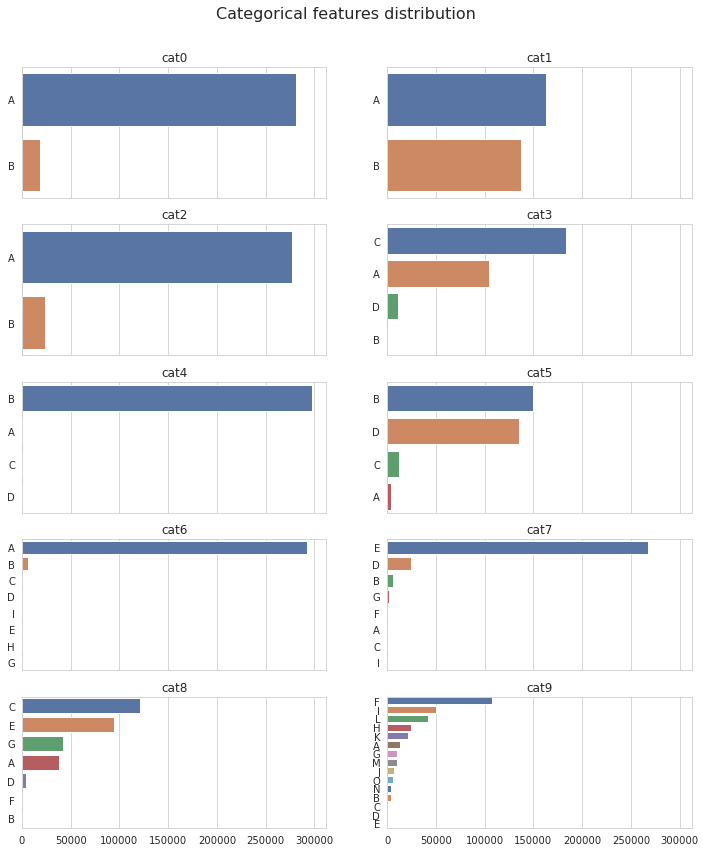

In [8]:
idx = 0
f, axes = plt.subplots(5, 2, sharex=True, figsize=(12,14))
plt.suptitle('Categorical features distribution', size=16, y=(0.94))

for row in range(5):
    for col in range(2):
        data = df_train[CAT[idx]].value_counts()
        sns.barplot(x = data.values, y = data.index, palette='deep', ax=axes[row, col])
        axes[row,col].set_title(CAT[idx])
        idx += 1

Seems like the next columns are non-informative: [cat0, cat2, cat4, cat6, cat7]. 
For the first time we will use all default columns for prediction. Later we try to remove "unimodal' ones.  

---

### Exploring continuous features 

In [9]:
NUM = df_train.select_dtypes('float64').columns.tolist()

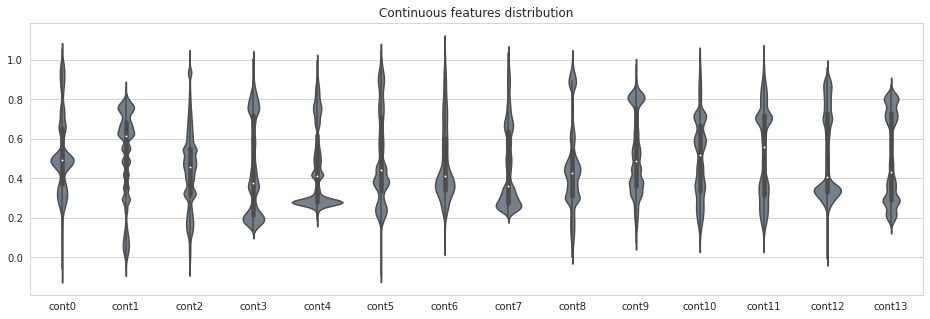

In [10]:
plt.figure(figsize=(16,5))
sns.violinplot(data=df_train[NUM], color='slategray')
plt.title('Continuous features distribution');

Not so bad. There are no columns with a huge amount of outliers. Four features have a highly skewed distribution [cont3, cont5, cont7 and cont1].  

Next step - check the correlations.

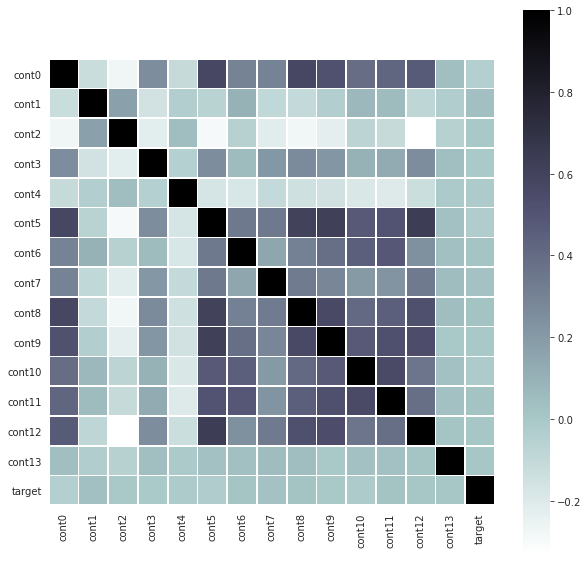

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train[NUM].join(target).corr(), square=True, linewidths=0.7, cmap="bone_r");

We have a few multicollinear columns. As I said previously, in this version I try to use these features by default. Next, we will try to use some more complicated algorithms.  

---

### Exploring target distribution

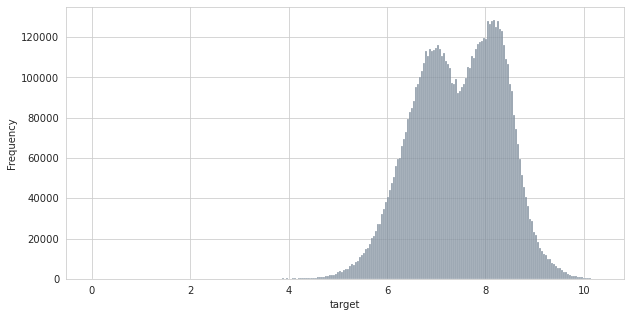

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(target, color='slategray', stat='frequency');

We have almost the same target bimodal distribution as in January playground competition.  
Also let's see how many values bellow mark 4 do we have here.

In [13]:
len(target[target <= 4])

34

Just 34 "outliers". Most likely we may drop them without a huge impact on a final score.

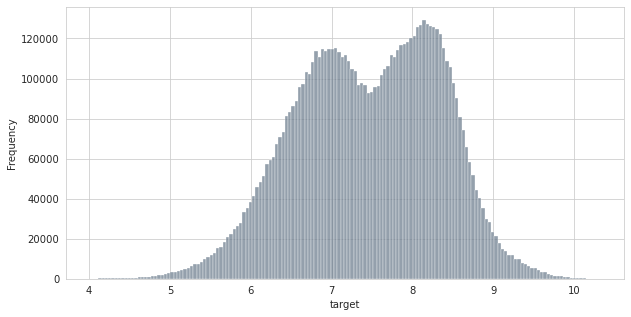

In [14]:
to_drop = target[target <= 4].index
target.drop(to_drop, inplace=True)
df_train.drop(to_drop, inplace=True)

plt.figure(figsize=(10,5))
sns.histplot(target, color='slategray', stat='frequency');

Much better.

## Machine learning

At this version we will use almost raw datasets with a touch of basic preprocessing.

---

### Categorical features encoding

In [15]:
CAT_01 = list(set(CAT).difference(set(['cat6'])))
CAT_01

['cat0', 'cat3', 'cat8', 'cat5', 'cat4', 'cat2', 'cat9', 'cat7', 'cat1']

#### Simple one-hot encoding

In [16]:
#dummies_train = pd.get_dummies(df_train[CAT_01])
#dummies_test = pd.get_dummies(df_test[CAT_01])

#train = df_train[NUM].join(dummies_train)
#test = df_test[NUM].join(dummies_test)

Feature 'cat6' has a label 'G' in training set, which is missed in test set. So after simply dummy transformation we have to drop 'cat6_G' feature from the updated train set.

In [17]:
#set(train.columns.tolist()).difference(set(test.columns.tolist()))

In [18]:
#train.drop('cat6_G', axis=1, inplace=True)
#train.shape[1], test.shape[1]

#### Label encoding

In [19]:
#for feature in CAT_01:
#    le = LabelEncoder()
#    le.fit(df_train[feature])
#    df_train[feature] = le.transform(df_train[feature])
#    df_test[feature] = le.transform(df_test[feature])

In [20]:
train = df_train.copy()
test = df_test.copy()

train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

train.shape, test.shape

((299966, 24), (200000, 24))

### Feature engineering 

#### Scaling and encoding

In [21]:
cols = train.columns.tolist()

ct = ColumnTransformer([('onehot',OrdinalEncoder(), slice(len(CAT))),
                        ('quantile',QuantileTransformer(random_state=SEED, n_quantiles=1500),
                         slice(len(CAT),len(CAT) + len(NUM) + 5))])

train = ct.fit_transform(train)
test = ct.transform(test)

train = pd.DataFrame(train, columns = cols)
test = pd.DataFrame(test, columns = cols)

train[CAT] = train[CAT] / 10
test[CAT] = test[CAT] / 10

#### Manual feature egineering

In [22]:
def feat_eng(df):
    
    # Manually multiply and drop specific columns
    
    #df['cont_003'] = df['cont0'] * df['cont8']

    df['cont001'] = df['cont8'] * df['cont0']
    df['cont002'] = df['cont9'] * df['cont0']
    df['cont003'] = df['cont9'] * df['cont5']
    df['cont004'] = df['cont8'] * df['cont5']
    df['cont005'] = df['cont2'] * df['cont4']
    df['cont006'] = df['cont1'] * df['cont3']
    df['cont007'] = df['cont13'] * df['cont1']
    
    #df['cat005'] = df['cat2'] * df['cat1']
   # df['cat006'] = df['cat2'] * df['cat4']
    
    #df.drop('cont5', axis=1, inplace=True)
    #df.drop('cont9', axis=1, inplace=True)
    
    return df

In [23]:
train = feat_eng(train)
test = feat_eng(test)

#train.drop('id', axis=1, inplace=True)
#test.drop('id', axis=1, inplace=True)

train.shape, test.shape

((299966, 31), (200000, 31))

#### FeatureTools

In [24]:
#to_transform = ['cont0', 'cont1', 'cont4', 'cont5', 'cont8', 'cont9', 'cont12'] 

In [25]:
def feat_eng_01(df):
    
    es = ft.EntitySet(id = 'data')

    original_cols = to_transform

    es = es.entity_from_dataframe(entity_id = 'data', 
                              dataframe = df[original_cols], 
                              index = 'id', 
                              time_index = None)
    
    new_features, new_feature_names = ft.dfs(entityset = es, target_entity = 'data', 
                                 trans_primitives = ['multiply_numeric'])
    
    new_features.reset_index(drop=True, inplace=True)
    new_features.drop(original_cols, axis=1, inplace=True)
    
    return new_features

In [26]:
#train_fe = feat_eng_01(train)
#test_fe = feat_eng_01(test)

#train_fe.index = train.index
#test_fe.index = test.index

#train = train.join(train_fe)
#test = test.join(test_fe)

#train.shape, test.shape

### Feature selection

In [27]:
#X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.1, random_state=SEED)

### FitPredict  

**Catboost with kFold**

catboost_params = { 
            'iterations':10000,
            'learning_rate':0.004,
            'depth':9,
            'num_leaves':111,
            'random_strength':3,
            'min_data_in_leaf':10,
            'l2_leaf_reg':5.2,
            'loss_function':'RMSE',
            'random_seed':SEED,
            'eval_metric':'RMSE',
            'grow_policy':'Depthwise',
            'max_bin':512,
            'task_type': 'GPU',
            'od_type':'Iter',
            'od_wait':50,
            'metric_period':50
            }

N_FOLDS = 5

kf = KFold(n_splits = N_FOLDS)
oof = np.zeros(len(target))

preds_folds = np.zeros(len(test))

for train_ind, test_ind in tqdm(kf.split(train)):
    X_train = train.iloc[train_ind]
    X_val = train.iloc[test_ind]
    y_train = target.iloc[train_ind]
    y_val = target.iloc[test_ind]

    model = cb.CatBoostRegressor(**catboost_params)
    
    train_pool = cb.Pool(X_train, y_train)
    val_pool = cb.Pool(X_val, y_val)
    
    model.fit(X_train, y=y_train, 
              eval_set = (X_val, y_val),  
              early_stopping_rounds=100, 
              verbose_eval=500, 
              use_best_model=True, 
              cat_features=train[CAT].columns.tolist(),
              plot=False)
    
    p = model.predict(X_val)
    oof[test_ind] = p
    preds_folds += model.predict(test)/N_FOLDS
    
    #print(np.round(mean_squared_error(y_val, p, squared=False),5))
        
print(f'mean square error on training data: {np.round(mean_squared_error(target, oof, squared=False),5)}')

0.84351

cb best RMSE on oof 0.8427

**LGBm with kfold**

lgb_params_kfold = {
 
    'n_estimators':6000,
    'learning_rate': 0.004,
    'min_child_samples':285,
    'boosting_type': 'gbdt',
    'num_leaves': 256,
    'max_depth': -1,
    'lambda_l1': 4.5,
    'lambda_l2': 1.2,
    'subsample':0.8,
    #'categorical_feature':CAT_FEAT,
    
    'device_type':'gpu',
    'metric': 'rmse',
    'cat_smooth': 39,
    'silent': True,
    'importance_type': 'split',
    'feature_pre_filter': False,
    'bagging_fraction': 0.85,
    'min_data_in_leaf': 100,
    #'min_data_per_group': 5,
    #'min_sum_hessian_in_leaf': 0.01,
    #'bagging_freq': 5,
    #'feature_fraction': 0.7,
    #'min_child_samples': 20,
    
    'n_jobs': -1,
    'random_state': SEED}

lgb_params_kfold = {
     'reg_alpha': 6.147694913504962,
     'reg_lambda': 0.002457826062076097,
     'colsample_bytree': 0.3,
     'subsample': 0.8,
     'learning_rate': 0.001,
     'max_depth': 20,
     'num_leaves': 111,
     'min_child_samples': 285,
     'random_state':SEED,
     'verbose':-1,
     'n_estimators': 30000,
     'metric': 'rmse',
     'cat_smooth': 39
}

N_FOLDS = 5

kf = KFold(n_splits = N_FOLDS)
oof = np.zeros(len(target))

preds_folds_lgb = np.zeros(len(test))


for train_ind, test_ind in tqdm(kf.split(train)):
    X_train = train.iloc[train_ind]
    X_val = train.iloc[test_ind]
    y_train = target.iloc[train_ind]
    y_val = target.iloc[test_ind]

    model = lgb.LGBMRegressor(**lgb_params_kfold)
    
    model.fit(X_train, y_train, eval_set = ((X_val, y_val)), early_stopping_rounds = 200, verbose = 1000)
    p = model.predict(X_val)
    oof[test_ind] = p

    preds_folds_lgb += model.predict(test)/N_FOLDS
        
print(f'mean square error on training data: {np.round(mean_squared_error(target, oof, squared=False),5)}')

best attempt - RMSE on training data: 0.84215

**xgb**

In [28]:
xgb_params = {
    'booster':'gbtree',
    'n_estimators':20000,
    'max_depth':5, 
    'eta':0.008,
    'gamma':3.5,
    'objective':'reg:squarederror',
    'verbosity':0,
    'subsample':0.75,
    'colsample_bytree':0.35,
    'reg_lambda':0.23,
    'reg_alpha':0.52,
    'scale_pos_weight':1,
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    #'seed':SEED,
    'tree_method':'gpu_hist',
    'gpu_id':0
}

In [29]:
N_FOLDS = 10

kf = KFold(n_splits = N_FOLDS)
oof = np.zeros(len(target))

preds_folds_xgb = np.zeros(len(test))


for train_ind, test_ind in tqdm(kf.split(train)):
    X_train = train.iloc[train_ind]
    X_val = train.iloc[test_ind]
    y_train = target.iloc[train_ind]
    y_val = target.iloc[test_ind]

    model = XGBRegressor(**xgb_params)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 50, verbose = False)
    p = model.predict(X_val)
    oof[test_ind] = p

    preds_folds_xgb += model.predict(test)/N_FOLDS

10it [04:42, 28.29s/it]


In [30]:
print(f'rmse on oof: {np.round(mean_squared_error(target, oof, squared=False),5)}')

rmse on oof: 0.84254


best rmse:  
0.84252  
0.84194

Using shape to get some info from XGB model and training features.

In [31]:
#shap_values = shap.TreeExplainer(model).shap_values(X_train)
#shap.summary_plot(shap_values, X_train)
#shap_interactions = model.predict(test)
#shap_preds = model.predict(test)

In [32]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
#plot_top_k_interactions(test.columns.tolist(), shap_interactions, 10)

In [33]:
#to_drop_shap = ['cat8_G', 'cat1_B', 'cat3_A', 'cont12', 'cont7', 'cat3_C', 'cat9_L', 'cat9_I', 'cont10']

#train_shap = train.copy()
#test_shap = test.copy()

#train_shap.drop(to_drop_shap, axis=1, inplace=True)
#test_shap.drop(to_drop_shap, axis=1, inplace=True)
#train_shap.shape, train.shape

N_FOLDS = 10

kf = KFold(n_splits = N_FOLDS)
oof = np.zeros(len(target))

preds_folds_xgb = np.zeros(len(test))


for train_ind, test_ind in tqdm(kf.split(train_shap)):
    X_train = train.iloc[train_ind]
    X_val = train.iloc[test_ind]
    y_train = target.iloc[train_ind]
    y_val = target.iloc[test_ind]

    model = XGBRegressor(**xgb_params)
    
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 50, verbose = False)
    p = model.predict(X_val)
    oof[test_ind] = p

    preds_folds_xgb += model.predict(test)/N_FOLDS
        
print(f'mean square error on training data: {np.round(mean_squared_error(target, oof, squared=False),5)}')

## Submission

Let's try to mix catboost and LGBM prediction from a previous version. You may find the code above.

In [34]:
avg_pred_01 = sub_202['target'] * 0.6 + sub_212['target'] * 0.4
avg_pred_02 = sub_202['target'] * 1.4 - sub_212['target'] * 0.4
avg_pred_03 = sub_202['target'] * 1.4 - sub_305['target'] * 0.4
avg_pred_04 = sub_202['target'] * 1.3 - preds_folds_xgb * 0.3
#avg_pred_05 = sub_216['target'] * 0.5 + preds_folds_xgb * 0.2 + sub_212['target'] * 0.3
#mixed_pred = preds_folds_xgb * 0.6 + sub_84295['target'] * 0.4

In [35]:
df_sub['target'] = avg_pred_01
df_sub.to_csv('submission_045.csv', index=False)

df_sub['target'] = avg_pred_02
df_sub.to_csv('submission_046.csv', index=False)

df_sub['target'] = avg_pred_03
df_sub.to_csv('submission_047.csv', index=False)

df_sub['target'] = avg_pred_04
df_sub.to_csv('submission_048.csv', index=False)

#df_sub['target'] = avg_pred_05
#df_sub.to_csv('submission_044.csv', index=False)

In [36]:
#plt.figure(figsize=(8,5))
#sns.histplot(avg_pred_01, color='slategray');

## Scoreboard and notes

**02/02/21**  *Public 0.84295*  

Simple EDA and preprocessing, tuned LGBR

**04/02/21** *Public: 0.84309 / 0.84322 / 0.84361*  

Basic feature engineering doesn't improve the score  

**05 and 06 02/21** *Public 0.84279*  

Xgb with shap feature impotrance, xgb + lbgm predictions  
pred xgb oof == 0.84194  pub_sub == 0.84279 

**10/02/21** *Public 0.84217*  
Mixed lightbgm and two different kfold XGB predictors  

**11/02/21** Publick 0.84212*  
LGBM 10 folds 0.83 public and average XGB preds from three different kernels;   
Touch of feature engineering, quantile transformation.


In [37]:
### best params  

lgb_params_kfold = {
 
    'n_estimators':3000,
    'learning_rate': 0.004,
    'min_data_per_group': 5,
    'boosting_type': 'gbdt',
    'num_leaves': 256,
    'max_depth': -1,
    'lambda_l1': 4.5,
    'lambda_l2': 1.2,
    
    'metric': 'rmse',
    'cat_smooth': 1.0,
    'silent': True,
    'importance_type': 'split',
    'feature_pre_filter': False,
    'bagging_fraction': 0.85,
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 0.001,
    'bagging_freq': 7,
    'feature_fraction': 0.5,
    'min_gain_to_split': 0.0,
    'min_child_samples': 20,
    
    'n_jobs': -1,
    'random_state': SEED}


xgb_params = {
    'booster':'gbtree',
    'n_estimators':10000,
    'max_depth':5, 
    'eta':0.006,
    'gamma':1.2,
    'objective':'reg:squarederror',
    'verbosity':0,
    'subsample':0.85,
    'colsample_bytree':0.8,
    'lambda':4.5,
    'alpha':1.2,
    'scale_pos_weight':1,
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'seed':SEED,
    'tree_method':'gpu_hist',
    'gpu_id':0
}

xgb_params = {
    'booster':'gbtree',
    'n_estimators':10000,
    'max_depth':7, 
    'eta':0.01,
    'gamma':1.8,
    'objective':'reg:squarederror',
    'verbosity':0,
    'subsample':0.85,
    'colsample_bytree':0.4,
    'lambda':2.7,
    'alpha':6,
    'scale_pos_weight':1,
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    'seed':SEED,
    'tree_method':'gpu_hist',
    'gpu_id':0
}